In [1]:
import pandas as pd
import numpy as np
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import gensim

from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabrina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('scrape/restaurant-data/cleaned_restaurant_reviews.csv', index_col=0).reset_index(drop=True)
data.head(5)

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
2,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
3,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
4,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East


## New Cleaning Code

In [3]:
import emoji
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

ps = PorterStemmer()

In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"o\'clock", "clock", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['address', 'note', 'tel', 'website', 'open', 'burpple']
add_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
    'won', "won't", 'wouldn', "wouldn't"])
add_stopwords_2 =  ['n','s','m','i','1','2','3','4','5','6','7','8','9','10','one','two',
    'it','in','ve','well','could','would','really','also','even',
    'alway','always','still','never','much','thing','yet',
    'said','asked','did','go','got','do','make','know','think','come','going',
    'put','went','seem','order','ordered','give','eat','make','get']

stopwords.extend(new_stopwords)
stopwords.extend(add_stopwords)
stopwords.extend(add_stopwords_2)

In [6]:
cleaned_review_list = []
count = 0

for review in data['review']:
    # lower case
    review = review.lower()

    # deemojize
    review = emoji.demojize(review)

    # remove headers
    review = ' '.join(review.split('\n')[2:])

    # remove location (pushpin or location:)
    review = review.split('round_pushpin')[0]
    review = review.split('location:')[0]

    # clean punctuation
    review = re.sub(r'[^\w\s]', '', review)

    # tokenize
    tokens = word_tokenize(review)

    # remove stopwords and URLs
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if 'http' not in word]
    tokens = [word for word in tokens if 'www' not in word]

    # decontraction
    tokens = [decontracted(word) for word in tokens]

    ### to add in translation code... shld translate each token

    ### never do stemming (i see online ppl do doc2vec like nv do stemming.....)

    # concatenate tokens back
    cleaned_review = " ".join(tokens)
    cleaned_review_list.append(cleaned_review)

    if count%1000 == 0:
        print(count)
    count+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [7]:
# replace the old cleaned text
data['cleaned_text'] = cleaned_review_list

In [8]:
# concatenate all the reviews for each restaurant
restaurant_review_df = data[['url', 'cleaned_text']]
restaurant_review_df = restaurant_review_df.groupby(['url'], as_index = False).agg({'cleaned_text': ' '.join})
restaurant_review_df.head(5)

,url,cleaned_text
0,https://www.burpple.com/108-matcha-saro?bp_ref...,s850 strong matcha flavor soft serve topped wh...
1,https://www.burpple.com/136-hong-kong-street-f...,zhi char feast family loves tze char lost coun...
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,four hand dinner chef alvin chef jay legendary...
3,https://www.burpple.com/25-degrees-singapore?b...,oh yesh loveeeee burgers goooooood located hot...
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,signature firebird koreaninspired sandwich fri...


In [9]:
restaurant_review_df = restaurant_review_df.join(data.drop(['url', 'cleaned_text'], axis=1), how="left")

## Doc2Vec Modelling

In [101]:
tokenizer = RegexpTokenizer(r'\w+')
# stopword_set = set(stopwords.words('english'))

def nlp_clean(data):
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        # dlist = list(set(dlist).difference(stopword_set))
        new_data.append(dlist)
    return new_data

class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
              yield gensim.models.doc2vec.TaggedDocument(doc, [self.labels_list[idx]])

In [102]:
# tokenize reviews
tokenized_reviews = nlp_clean(restaurant_review_df['cleaned_text'])

In [103]:
def doc2vec(tokenized_reviews):
    # label reviews with the restaurant url
    it = LabeledLineSentence(tokenized_reviews, restaurant_review_df['url'])
    # (it.labels_list[0], it.doc_list[0])
    # doc2vec
    # word embeddings: calculate use frequency -> calculate cosine similarity -> group based on similar usage of words. (LDA just the first step)
    # vector size 1000 == randomly selecting 1000

    # pass in our own food dictionary such that the doc2vec generates vectors based on this dictionary
    model = gensim.models.Doc2Vec(vector_size=1000, min_count=5, alpha=0.025, min_alpha=0.025) #### TO TUNE
    model.build_vocab(it) #### check documentation for this? use build_vocab_from_freq instead?? 
    model.train(it, total_examples= model.corpus_count, epochs = 10, start_alpha=0.002, end_alpha=-0.016)

    print(model.corpus_count) ## check the corpus
    print(len(model.docvecs)) # check doc2vec. Doesn't work on newest version.

    ### plot the accuracy of each epoch so we can see if its over or under-fitted
    ### tweak learning rate and number of epochs
    return model

#### normal

In [104]:
model = doc2vec(tokenized_reviews)

845
845


#### bigram

In [133]:
from gensim.models.phrases import Phrases, Phraser
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

bigram_reviews = make_bigrams(tokenized_reviews)

In [134]:
model = doc2vec(bigram_reviews)

845
845


#### Trigram

In [130]:
from gensim.models.phrases import Phrases, Phraser
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram_mod['tokenized_reviews'])
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

trigram_reviews = make_trigrams(tokenized_reviews)

In [132]:
model = doc2vec(trigram_reviews)

845
845


## Similarity

In [135]:
# get most similar restaurant to the first restaurant
# 'https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes'
model.docvecs.most_similar(0)

[('https://www.burpple.com/tonito-latin-american-kitchen?bp_ref=%2Ff%2FNFt7UP9_',
  0.9999985098838806),
 ('https://www.burpple.com/wild-olives?bp_ref=%2Ff%2FJxToy659',
  0.9999984502792358),
 ('https://www.burpple.com/swensens-plaza-singapura?bp_ref=%2Ff%2FDogg6dP4',
  0.9999983906745911),
 ('https://www.burpple.com/toms-palette?bp_ref=%2Ff%2FgSOcauwM',
  0.9999983906745911),
 ('https://www.burpple.com/monti?bp_ref=%2Ff%2F5c1E67PG', 0.9999983310699463),
 ('https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv',
  0.9999983310699463),
 ('https://www.burpple.com/amo-restaurant?bp_ref=%2F%40therealfoodcritic%2Ftimeline',
  0.9999983310699463),
 ('https://www.burpple.com/bakerybrera?bp_ref=%2F%40timtam_tum%2Ftimeline',
  0.9999983310699463),
 ('https://www.burpple.com/crystal-jade-palace-restaurant?bp_ref=%2Ff%2FTxgLmMOG',
  0.9999982714653015),
 ('https://www.burpple.com/the-assembly-ground?bp_ref=%2Ff%2F0IhEnQgA',
  0.9999982714653015)]

In [136]:
# similarity between 2 documents
model.docvecs.similarity(it.labels_list[0], it.labels_list[1])

0.9999945

In [137]:
similarity_df = pd.DataFrame()

for restaurant in it.labels_list:
    similarity_list = []
    for restaurant2 in it.labels_list:
        similarity_list.append(model.docvecs.similarity(restaurant, restaurant2))
    
    similarity_df[restaurant] = similarity_list

In [138]:
similarity_df.index = list(it.labels_list)

In [139]:
similarity_df

# cosine similarity, jacquard smilarity, euclidean distance, manhatten distance

# similarity scores high coz vectors are similar
# currently, the vectors are too random. embedding method is not capturing the important data regarding the food items. pre-process dataset to remove words / give more importance to some words

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999995,0.999998,0.999997,0.999997,0.999996,0.999997,0.999995,0.999994,0.999996,...,0.999998,0.999998,0.999996,0.999996,0.999998,0.999998,0.999998,0.999996,0.999996,0.999997
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999995,1.000000,0.999996,0.999995,0.999995,0.999994,0.999994,0.999992,0.999991,0.999994,...,0.999996,0.999996,0.999993,0.999994,0.999995,0.999995,0.999995,0.999993,0.999994,0.999994
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999998,0.999996,1.000000,0.999998,0.999999,0.999998,0.999998,0.999996,0.999995,0.999997,...,0.999999,0.999999,0.999997,0.999997,0.999999,0.999999,0.999999,0.999997,0.999998,0.999998
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999997,0.999995,0.999998,1.000000,0.999998,0.999997,0.999997,0.999995,0.999994,0.999996,...,0.999998,0.999998,0.999996,0.999996,0.999998,0.999998,0.999998,0.999996,0.999997,0.999997
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999997,0.999995,0.999999,0.999998,1.000000,0.999997,0.999997,0.999996,0.999994,0.999997,...,0.999999,0.999999,0.999997,0.999997,0.999998,0.999998,0.999998,0.999996,0.999997,0.999997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999998,0.999995,0.999999,0.999998,0.999998,0.999997,0.999997,0.999996,0.999994,0.999997,...,0.999999,0.999999,0.999997,0.999997,0.999998,1.000000,0.999998,0.999997,0.999997,0.999997
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999998,0.999995,0.999999,0.999998,0.999998,0.999997,0.999997,0.999996,0.999994,0.999996,...,0.999999,0.999999,0.999997,0.999997,0.999998,0.999998,1.000000,0.999996,0.999997,0.999997
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999996,0.999993,0.999997,0.999996,0.999996,0.999995,0.999995,0.999994,0.999992,0.999995,...,0.999997,0.999997,0.999995,0.999995,0.999997,0.999997,0.999996,1.000000,0.999995,0.999995
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999996,0.999994,0.999998,0.999997,0.999997,0.999996,0.999996,0.999995,0.999993,0.999995,...,0.999998,0.999998,0.999995,0.999996,0.999997,0.999997,0.999997,0.999995,1.000000,0.999996


In [113]:
similarity_df.to_csv('doc2vec_restaurant_similarity_new_cleaning_bigrams.csv')

## Text Clustering using K-Means
by default kmeans uses euclidean distance

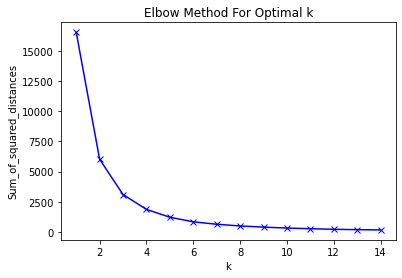

In [140]:
# get optimal number of topics
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    X = kmeans.fit(model.dv.vectors) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [141]:
# elbow result shows 8 is the best
num_clusters = 6 ## or change to 6?
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model.dv.vectors)
labels = kmeans.labels_.tolist()

# can get the representative words of each category 
# cosine similarity measure of the words
# LDA uses number of words in each review (prob of word uses)

In [142]:
l = kmeans.fit_predict(model.docvecs.vectors)
pca = PCA(n_components=2).fit(model.docvecs.vectors)
datapoint = pca.transform(model.docvecs.vectors)

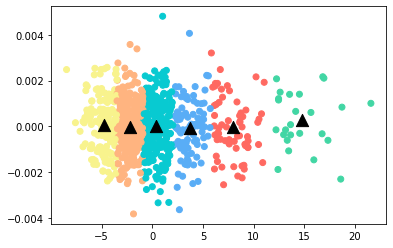

In [143]:
plt.figure
label1 = ["#FF6961", "#FFB480", "#F8F38D", "#42D6A4", "#08CAD1", "#59ADF6", "#9D94FF", "#C780E8"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

# if clustering not well, means word embedding is not clearly representing the topic
# get a set of food items from wikipedia & set of sentiment words (e.g. good, nice, awful, costly) words that are freuently in reviews
# find the frequency of these words in the dataset??
# use n-grams?

In [144]:
# label each restaurant under 1 of the topics
restaurant_review_df['topics'] = labels

In [145]:
# count of restaurants under each topic
restaurant_review_df['topics'].value_counts()

1    260
4    240
2    159
5     97
0     64
3     25
Name: topics, dtype: int64

In [146]:
restaurant_review_df.head(5)

,url,cleaned_text,name,neighbourhood,price,categories,review,user,date,cleaned_price,...,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region,topics
0,https://www.burpple.com/108-matcha-saro?bp_ref...,s850 strong matcha flavor soft serve topped wh...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,...,0,0,0,0,0,1,0,0,East,4
1,https://www.burpple.com/136-hong-kong-street-f...,zhi char feast family loves tze char lost coun...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,...,0,0,0,0,0,1,0,0,East,2
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,four hand dinner chef alvin chef jay legendary...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,...,0,0,0,0,0,1,0,0,East,3
3,https://www.burpple.com/25-degrees-singapore?b...,oh yesh loveeeee burgers goooooood located hot...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,...,0,0,0,0,0,1,0,0,East,4
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,signature firebird koreaninspired sandwich fri...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,...,0,0,0,0,0,1,0,0,East,5


## Interpret Clusters
identify restaurants that are closest to the centroid

In [30]:
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(kmeans.cluster_centers_, model.docvecs.doctag_syn0, metric='euclidean')
closest_indexes = [np.argpartition(i, 10)[:10] for i in distances] # for each centroid, get the 10 nearest restaurants

In [31]:
interpret_df = pd.DataFrame(columns=['topics', 'url', 'cleaned_text'])
for idx in closest_indexes:
    interpret_df = interpret_df.append(restaurant_review_df[['url', 'cleaned_text', 'topics']].iloc[idx])

interpret_df = interpret_df.sort_values(['topics'])

In [37]:
interpret_df.to_csv('doc2vec_centroid_restaurants_' + str(num_clusters) + '_clusters_new_cleaning.csv')

In [33]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,cleaned_text
537,0,https://www.burpple.com/one-fattened-calf?bp_r...,unique menu available dinein ofcs butterburger...
238,0,https://www.burpple.com/flipperssingapore?bp_r...,pancakes light fluffy good sized portions enjo...
739,0,https://www.burpple.com/the-masses?bp_ref=%2Ff...,random saturday evening family decided treatyo...
304,0,https://www.burpple.com/hill-street-tai-hwa-po...,im pleased favourite bak chor mee overly crowd...
705,0,https://www.burpple.com/teochew-fishball-old-a...,red bean chendol 230 nonya chendol 01115 delic...
643,0,https://www.burpple.com/si-chuan-dou-hua-resta...,dont miss outletexclusive item accompanied spr...
536,0,https://www.burpple.com/onalu?bp_ref=%2F%40tas...,classic bec charcoal bagel 11 something fishy ...
840,0,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2...,stir fried yunnan rice noodles assorted seafoo...
183,0,https://www.burpple.com/cupping-room-coffee-ro...,matcha latte w oat milk 690 finally drink 2022...
100,0,https://www.burpple.com/bread-street-kitchen-s...,huge portion fish chips makes price point pret...


## One Hot Encode

In [123]:
restaurant_review_df_encoded = restaurant_review_df.drop(['name', 'cleaned_text', 'price', 'categories', 'review', 'user', 'date', 'cleaned_categories'], axis=1)

In [124]:
# one hot encode region & topics
region_dummies = pd.get_dummies(restaurant_review_df_encoded['region'])
neighbourhood_dummies = pd.get_dummies(restaurant_review_df_encoded['neighbourhood'])
topic_dummies = pd.get_dummies(restaurant_review_df_encoded['topics'])

restaurant_review_df_encoded = restaurant_review_df_encoded.drop(['region', 'neighbourhood', 'topics'], axis=1)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(region_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(neighbourhood_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(topic_dummies)

In [125]:
restaurant_review_df_encoded.head(5)

,url,cleaned_price,Healthy,Noodles,Indian,Seafood,BBQ,High Tea,Good Environment,Chinese,...,Potong Pasir,Serangoon,Tanjong Pagar,Tiong Bahru,0,1,2,3,4,5
0,https://www.burpple.com/108-matcha-saro?bp_ref...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,https://www.burpple.com/136-hong-kong-street-f...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,https://www.burpple.com/25-degrees-singapore?b...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [126]:
restaurant_review_df_encoded.to_csv('doc2vec_labelled_restaurants_bigram.csv')

## WordCloud

In [127]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

ModuleNotFoundError: No module named 'wordcloud'

In [ ]:
# concatenate all the reviews for each topic
topic_df = interpret_df[['topics', 'cleaned_text']]
topic_df = topic_df.groupby(['topics'], as_index = False).agg({'cleaned_text': ' '.join})
topic_df

In [ ]:
# TF-IDF
text = topic_df['cleaned_text']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text)
feature_names = vectorizer.get_feature_names_out()
dense = X.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose()
df.columns = topic_df['topics']

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_text(text[0])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[0])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_text(text[1])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[1])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[2])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[3])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[4])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[5])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[6])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[7])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()